# Load / Prepare Dataset


In [73]:
import pandas as pd
import numpy as np

females = pd.read_table('Female')
males = pd.read_table('Male')

df = pd.concat([females, males]).drop(columns = 'Notes') # Merge

df = df.dropna()

df.head()

,Age Group,Age Group Code,Cause of death,Cause of death Code,Gender,Gender Code,Race,Race Code,Deaths,Population,Crude Rate
0,< 1 year,1,Other and unspecified gastroenteritis and coli...,A09.0,Female,F,Black or African American,2054-5,25.0,430996,6
1,< 1 year,1,Other and unspecified gastroenteritis and coli...,A09.0,Female,F,White,2106-3,42.0,2.72182e+06,2
2,< 1 year,1,"Whooping cough, unspecified",A37.9,Female,F,White,2106-3,16.0,2.72182e+06,1 (Unreliable)
3,< 1 year,1,Septicaemia due to other Gram-negative organisms,A41.5,Female,F,White,2106-3,26.0,2.72182e+06,1
4,< 1 year,1,"Septicaemia, unspecified",A41.9,Female,F,Black or African American,2054-5,37.0,430996,9


In [74]:
# Dropping unneeded columns.

df = df.drop(columns = ['Age Group Code',  'Race Code', 'Crude Rate', 'Gender Code']).reset_index(drop = True)

df.dtypes

Age Group               object
Cause of death          object
Cause of death Code     object
Gender                  object
Race                    object
Deaths                 float64
Population              object
dtype: object

In [0]:
# The Population needs to be changed to int. Let's do that.
df = df.replace('Not Applicable', np.NaN).dropna()

df['Population'] = df['Population'].astype(int)

In [76]:
print('Least common cause of death:', df['Cause of death'].min())
print('Most common cause of death:', df['Cause of death'].max()) # Interesting. Shingles is the most common cause of death

Least common cause of death: Abdomen - Malignant neoplasms
Most common cause of death: Zoster without complication


# Modeling

## Wrangle / Feature Engineering

In [0]:
def wrangle(X):
    X = X.copy() # Make a copy for warnings
    
    # Get first three of cause of death (classifies)
    X['Cause of Death Code'] = [x.strip()[:3] for x in X['Cause of death Code']]
    
    # Calculate Crude Rates
    X['Crude Rate'] = (X['Deaths'] / X['Population']) * 100000
    X = X.drop(columns = ['Cause of death Code']) # Drop the too-specific cause of death Code
    return X
    

## Decision Tree

In [78]:
!pip install category_encoders
# Imports

from sklearn.pipeline import make_pipeline 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
import category_encoders as ce

In [79]:
# Train - Val - Test Split
train, test = train_test_split(df, train_size = 0.8)
train, val = train_test_split(train, train_size = 0.5)

train.shape, val.shape, test.shape

((5300, 7), (5300, 7), (2650, 7))

In [80]:
# Wrangle all three.

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

train.head()

,Age Group,Cause of death,Gender,Race,Deaths,Population,Cause of Death Code,Crude Rate
11373,65-74 years,"Exposure to smoke, fire and flames, undetermin...",Male,White,13.0,10494201,Y26,0.123878
8176,35-44 years,Intentional self-poisoning by and exposure to ...,Male,White,15.0,25402313,X69,0.059050
2283,55-64 years,Sigmoid colon - Malignant neoplasms,Female,White,18.0,18286964,C18,0.098431
7049,20-24 years,Assault by unspecified means,Male,Black or African American,20.0,2200477,Y09,0.908894
4361,75-84 years,"Sarcoidosis, unspecified",Female,White,40.0,7504565,D86,0.533009


In [81]:
target = 'Cause of Death Code' # Feature we're trying to predict
features = train.columns.drop([target] + ['Cause of death',  'Crude Rate'])

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

X_val['Race'].value_counts()

White                               3696
Black or African American           1304
Asian or Pacific Islander            275
American Indian or Alaska Native      25
Name: Race, dtype: int64

In [82]:
# Make the Pipeline
pipeline = make_pipeline(
                          ce.OneHotEncoder(use_cat_names = True),
                         DecisionTreeClassifier(max_depth = 3,
                                                random_state = 321,
                                                max_leaf_nodes = 4,
                                                min_samples_leaf = 1,
                                                max_features = "auto"
                                               )
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Age Group', 'Gender', 'Race'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=3,
                                        max_features='auto', max_leaf_nodes=4,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=321,
                                 

In [0]:
baseline = pipeline.score(X_train, y_train) # Using accuracy score over ROC AUC because Multi-Class

In [0]:
val_score = pipeline.score(X_val, y_val)

In [85]:
print(f'Baseline Accuracy Score: {baseline}')
print(f'Validation Accuracy Score: {val_score}')

Baseline Accuracy Score: 0.014528301886792452
Validation Accuracy Score: 0.014150943396226415


# Linear Model


In [0]:
# Imports
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [0]:
log_pipe = make_pipeline(StandardScaler(),
                         ce.OrdinalEncoder(),
                         LogisticRegression(random_state = 321, max_iter = 100, n_jobs = -1)
)

In [0]:
# Encode all Values
encoder = ce.OrdinalEncoder()

X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

In [89]:
log_pipe.fit(X_train_encoded, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=-1, penalty='l2',
                                    random_state=321, solver='lbfgs',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [90]:
print('Train Score:', log_pipe.score(X_train_encoded, y_train))

Train Score: 0.02358490566037736


In [91]:
print('Validation Score:', log_pipe.score(X_val_encoded, y_train))

Validation Score: 0.011886792452830188


## Test Scores

In [92]:
print('Test Score (Decision Tree):', pipeline.score(X_test, y_test))
print('Test Score (Linear Model):', log_pipe.score(X_test_encoded, y_test))

Test Score (Decision Tree): 0.01471698113207547
Test Score (Linear Model): 0.01471698113207547


# Model Visualizations

## Visualize Decision Tree

In [0]:
# Imports and Setup
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import display, HTML

In [0]:
# Encode Columns; Define Model

encoder = pipeline.named_steps.onehotencoder
model = pipeline.named_steps.decisiontreeclassifier

encoded_columns = encoder.transform(X_train).columns

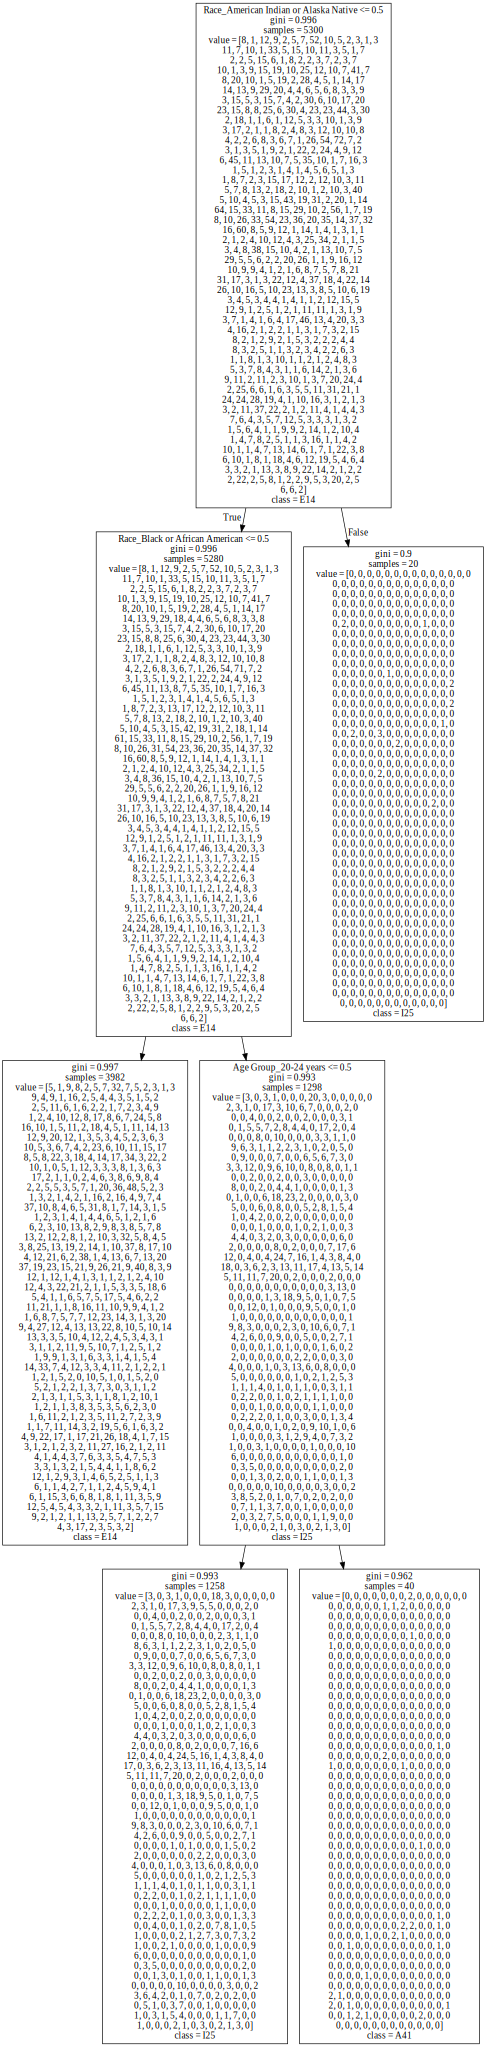

In [95]:
dot_data = export_graphviz(model, 
 out_file = None, 
 class_names = model.classes_,
 feature_names = encoded_columns)

display(graphviz.Source(dot_data))


## Feature Importances


In [96]:
importances = pd.Series(pipeline.named_steps.decisiontreeclassifier.feature_importances_, encoded_columns)

importances = importances.sort_values(ascending = False)[:3]

importances

Race_Black or African American           0.397129
Race_American Indian or Alaska Native    0.352518
Age Group_20-24 years                    0.250353
dtype: float64

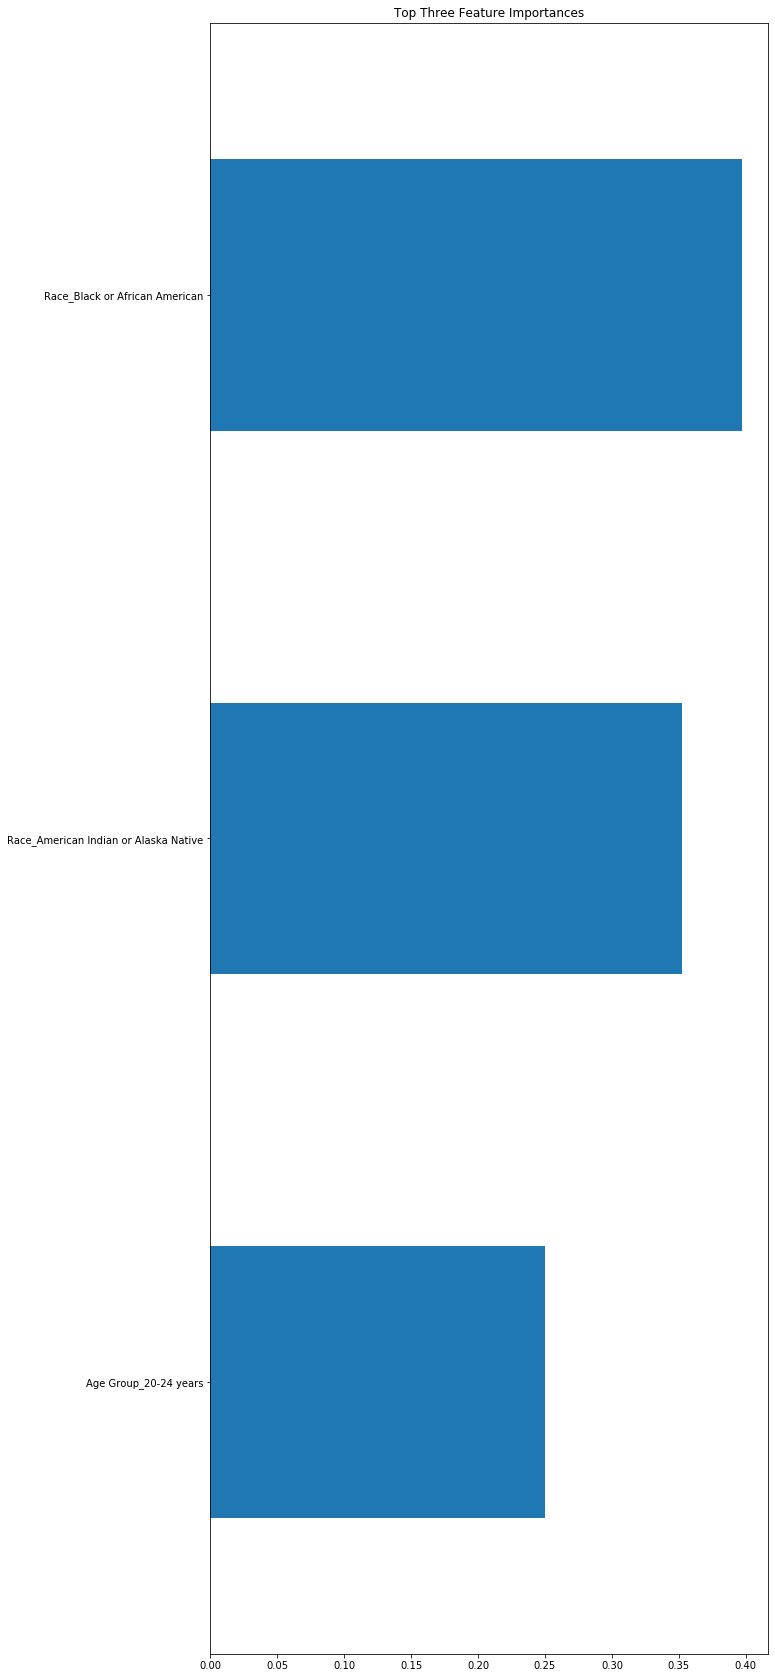

In [97]:
import matplotlib.pyplot as plt


plt.figure(figsize = (10, 30))
plt.title('Top Three Feature Importances')

importances.sort_values().plot.barh();

# Causes of Death by Race

In [0]:
# Calculating Crude Rate
import plotly.express as px
df['Crude Rate'] = (df['Deaths'] / df['Population']) * 100000
df['Cause of Death Class'] = [x.strip()[:1] for x in df['Cause of death Code']]

In [121]:
fig = px.bar(df, x = 'Race', y = 'Crude Rate', color = 'Cause of Death Class', title = 'Cause of Death Classifications (Refer to ICD-10)')
fig.update_layout(
        showlegend = False) # I can't seem to get this styled right to where the legend is showing, and not cutting any values off.
                            # I'm going to do a second one for this, to capture the legend for blog post...


fig.show()

In [124]:
fig.update_layout(
        showlegend = True,
        legend_orientation="h")
fig.update_xaxes(showticklabels=False)

fig.show()